In [1]:
from keras.layers.core import Activation, Dense, Dropout, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os

Using TensorFlow backend.


In [42]:
maxlen = 0
word_freqs = collections.Counter()
num_recs = 0
ftrain = open("./training.txt", 'rb')
for line in ftrain:
    label, sentence = line.strip().split(b"\t")
    words = nltk.word_tokenize(sentence.decode("ascii", "ignore").lower())
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        word_freqs[word] += 1
    num_recs += 1
ftrain.close()

In [50]:
print(maxlen)
print(len(word_freqs))
print(word_freqs)

42
2311
Counter({'i': 4707, ',': 4194, '.': 3558, 'the': 3221, 'and': 2150, '!': 2131, 'harry': 2088, 'vinci': 2001, 'da': 1998, 'brokeback': 1996, 'code': 1986, 'mountain': 1982, 'potter': 1817, '...': 1685, 'love': 1542, 'is': 1521, 'a': 1305, 'was': 1179, 'mission': 1090, 'impossible': 1089, 'awesome': 1028, 'like': 974, 'it': 897, 'to': 808, 'movie': 777, 'that': 718, "'s": 629, 'because': 608, 'sucks': 593, 'hate': 578, 'sucked': 509, 'so': 506, 'as': 473, 'my': 462, '``': 449, 'much': 446, 'of': 424, 'really': 374, 'movies': 366, 'stupid': 365, 'you': 329, 'down': 322, 'we': 295, 'but': 295, 'be': 290, 'with': 288, 'just': 287, 'one': 283, 'know': 276, 'potter..': 276, 'suck': 273, 'out': 269, '3': 267, '/': 263, 'who': 263, 'or': 263, 'am': 260, 'loved': 256, 'want': 254, 'into': 253, 'which': 251, 'right': 249, 'for': 241, 'an': 225, "n't": 223, 'this': 213, 'me': 212, ':': 207, 'are': 203, 'think': 202, 'not': 198, 'how': 197, 'if': 195, 'depressing': 188, 'people': 183, 'his'

In [48]:
MAX_FEATURES = 2000
MAX_SENTENCE_LENGTH = 40

vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
word2index = {x[0]: i+2 for i, x in
              enumerate(word_freqs.most_common(MAX_FEATURES))}
word2index["PAD"] = 0 # used for padding sentences to a fixed number of words
word2index["UNK"] = 1 # out of vocabulary
index2word = {v:k for k, v in word2index.items()}

In [49]:
print(vocab_size)
print(word2index)

2002
{'aka': 644, 'hedge': 534, 'honestly': 960, 'fairly': 1483, 'latter': 1853, 'questions': 962, 'bogus': 449, 'signs': 964, 'learn': 965, 'think': 71, 'imagine': 967, 'clubbin': 968, 'ones..': 1016, 'happen': 970, 'costume': 645, 'guy': 94, 'lousy': 646, 'community': 192, 'ok': 95, 'gl': 1030, 'doing': 448, 'liked': 122, 'blame': 729, 'frakking': 972, 'ticket': 647, 'tournament..': 973, 'm': 535, 'independent': 974, 'most': 118, 'veil': 975, 'mirror': 665, 'having': 387, 'bullshit': 539, 'respect': 668, 'alarm': 981, 'hp': 648, 'once': 510, 'otp': 983, 'knew': 649, 'dungeons': 984, 'calls': 986, 'johnny': 650, 'sue-ism': 987, 'gym': 988, 'film': 136, 'silver': 990, 'share': 991, 'spin': 1157, 'station': 281, 'exaggeration': 963, 'school': 416, 'every': 417, 'heresies': 1859, 'yet': 388, 'stayed': 536, 'nothin': 995, 'post': 996, 'plausible': 997, 'runs': 1310, 'empty': 691, 'story': 89, 'kirsten': 228, 'make': 178, 'public': 1000, 'catch': 652, 'instead..': 985, 'wacked': 1003, 'goo

In [32]:
X = np.empty((num_recs, ), dtype=list)
y = np.zeros((num_recs, ))
i = 0
ftrain = open("./training.txt", 'rb')
for line in ftrain:
    label, sentence = line.strip().split(b"\t")
    words = nltk.word_tokenize(sentence.decode("ascii", "ignore").lower())
    seqs = []
    for word in words:
        if word in word2index:
            seqs.append(word2index[word])
        else:
            seqs.append(word2index["UNK"])
    X[i] = seqs
    y[i] = int(label)
    i += 1
ftrain.close()
X = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LENGTH)

In [33]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 10

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_SENTENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

W0717 09:59:18.600627 139952579901184 deprecation_wrapper.py:119] From /Home2/smryoo/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0717 09:59:18.609017 139952579901184 deprecation.py:506] From /Home2/smryoo/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0717 09:59:18.982778 139952579901184 deprecation_wrapper.py:119] From /Home2/smryoo/.local/lib/python3.5/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0717 09:59:18.995649 139952579901184 deprecation_wrapper.py:119] From /Home2/smryoo/.local/lib/pyt

In [36]:
history = model.fit(Xtrain, ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
    validation_data=(Xtest, ytest))

Train on 5668 samples, validate on 1418 samples
Epoch 1/10
5668/5668 [==============================] - 16s 3ms/step - loss: 0.2396 - acc: 0.9001 - val_loss: 0.0700 - val_acc: 0.9746
Epoch 2/10
5668/5668 [==============================] - 15s 3ms/step - loss: 0.0296 - acc: 0.9906 - val_loss: 0.0501 - val_acc: 0.9817
Epoch 3/10
5668/5668 [==============================] - 16s 3ms/step - loss: 0.0124 - acc: 0.9966 - val_loss: 0.0357 - val_acc: 0.9873
Epoch 4/10
5668/5668 [==============================] - 16s 3ms/step - loss: 0.0069 - acc: 0.9984 - val_loss: 0.0576 - val_acc: 0.9852
Epoch 5/10
5668/5668 [==============================] - 15s 3ms/step - loss: 0.0027 - acc: 0.9995 - val_loss: 0.0386 - val_acc: 0.9915
Epoch 6/10
5668/5668 [==============================] - 15s 3ms/step - loss: 0.0066 - acc: 0.9977 - val_loss: 0.0459 - val_acc: 0.9866
Epoch 7/10
5668/5668 [==============================] - 15s 3ms/step - loss: 0.0026 - acc: 0.9993 - val_loss: 0.0370 - val_acc: 0.9887
Epoch 8

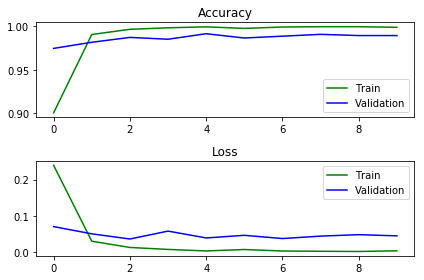

In [37]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [41]:
score, acc = model.evaluate(Xtest, ytest, batch_size=BATCH_SIZE)
print("Test score: %.3f, accuracy: %.3f" % (score, acc))
print('pred\tlabel\tsentence')
for i in range(5):
    idx = np.random.randint(len(Xtest))
    xtest = Xtest[idx].reshape(1,40)
    ylabel = ytest[idx]
    ypred = model.predict(xtest)[0][0]
    sent = " ".join([index2word[x] for x in xtest[0].tolist() if x != 0])
    print("%.0f\t%d\t%s" % (ypred, ylabel, sent))

1418/1418 [==============================] - 0s 348us/step
Test score: 0.044, accuracy: 0.989
pred	label	sentence
0	0	not because i hate harry potter , but because i am the type of person that likes it when the main character dies .
0	0	then again , the da vinci code is super shitty movie , and it made like 700 million .
0	0	my dad 's being stupid about brokeback mountain ...
1	1	i love kirsten / leah / kate escapades and mission impossible tom as well ...
0	0	as i sit here , watching the mtv movie awards , i am reminded of how much i despised the movie brokeback mountain .


In [44]:
print(X.shape)
print(X)

(7086, 40)
[[  0   0   0 ...  48  22   4]
 [  0   0   0 ... 340  67   4]
 [  0   0   0 ...  18 324   4]
 ...
 [  0   0   0 ...  11  13   4]
 [  0   0   0 ... 126  26   4]
 [  0   0   0 ...  87  26   4]]


In [46]:
print(y.shape)
print(y)

(7086,)
[1. 1. 1. ... 0. 0. 0.]
